In [1]:
%cd ..

/home/jovyan/work/spectrum/c_final/v1


In [2]:
import pandas as pd
import base
import os
import pickle
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping 
from keras.models import load_model

from datetime import datetime

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.manifold import TSNE
import seaborn as sns

2024-02-27 09:08:06.588255: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 09:08:06.623676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 09:08:06.623711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 09:08:06.624603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 09:08:06.630692: I tensorflow/core/platform/cpu_feature_guar

In [3]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

Checking cal_mod

In [4]:
df_neg = pd.read_csv('Data/02_basedata/neg/df_neg.csv' )

df_neg['modnum'] = base.cal_mod(df_neg['AverageMz'])
df_negx = df_neg[df_neg['Ontology'].isin(['EtherPC','PC'])] 

df_negx.loc[:,'Ontology'] = df_negx.loc[:,'Ontology'].astype(str)

In [5]:
base.create_mspfile_fromdf(df_negx, 'PC-EtherPC_negdata', ionmode = 'Negative')

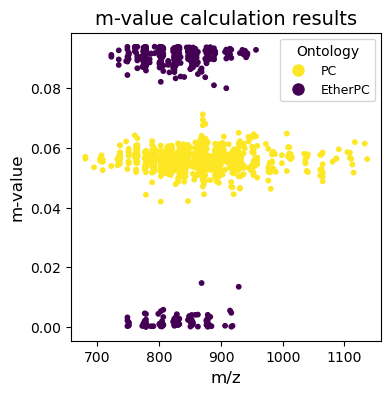

In [7]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

df_negx.loc[:,'OntologyCode'] = pd.Categorical(df_negx.loc[:,'Ontology']).codes
scatter = plt.scatter(df_negx['AverageMz'], df_negx['modnum'], c=df_negx['OntologyCode'], cmap='viridis', s=10)

plt.xlabel('m/z', fontsize=12)
plt.ylabel('m-value', fontsize=12)
plt.title('m-value calculation results', fontsize=14)

legend_labels = df_negx['Ontology'].unique()
legend_labels_numeric = df_negx['Ontology'].astype('category').cat.codes.unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10) for label in legend_labels_numeric]
plt.legend(legend_handles, legend_labels, title='Ontology', loc='upper right', fontsize=9)

#plt.savefig('Data/03_model/neg/fig_neg_mvalue.svg', dpi=300, bbox_inches='tight')

make tabledata

In [8]:
df_neg_data = pd.read_csv('Data/02_basedata/neg/df_neg_data_.csv').query('Ontology not in ["FA","Others"]')
ontlist = pd.DataFrame(df_neg_data.Ontology.value_counts()).reset_index().query('count >= 4').Ontology.tolist()
df_neg_data2 = df_neg_data[df_neg_data['Ontology'].isin(ontlist)].reset_index(drop=True).reset_index(drop=True)

In [9]:
df_neg = pd.read_csv('Data/02_basedata/neg/df_neg.csv' )

df_neg['div2'] = df_neg['AverageMz'].round().astype(int) % 2
df_neg['modnum'] = base.cal_mod(df_neg['AverageMz'])

In [10]:
df_neg_data2x = df_neg_data2.merge(df_neg[['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz','div2','modnum']], how='left',\
    on=['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz'])
df_neg_data2x.to_csv('Data/02_basedata/neg/neg2.csv', index=False)

In [11]:
## train/test/eval
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_neg_data2x.drop(columns=columns_to_drop).astype(float).values
y = df_neg_data2x['Ontology']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
train_d, test_d = train_test_split(df_neg_data2x, test_size=0.2, random_state=42)

columnslist = df_neg_data2x.drop(columns=columns_to_drop).columns
with open('Data/03_model/neg/negmodelcolumn_all.pkl', 'wb') as file:
    pickle.dump(columnslist, file)

replacement_dict = base.replacement_dict_mapping(df_neg_data2x.Ontology.drop_duplicates().tolist())

with open('Data/03_model/neg/neg_replacement_dict_all.pkl', 'wb') as file:
    pickle.dump(replacement_dict, file)

y_test.to_csv('Data/04_canopus/neg/df_neg_ytest.csv')

NN

In [14]:
y_train_replaced0 = y_train.replace(replacement_dict).to_numpy().astype('int64')
y_test_replaced0 = y_test.replace(replacement_dict).to_numpy().astype('int64')
y_eval_replaced0 = y_eval.replace(replacement_dict).to_numpy().astype('int64')

y_train_onehot = to_categorical(y_train_replaced0, len(ontlist))
y_test_onehot = to_categorical(y_test_replaced0, len(ontlist))
y_eval_onehot = to_categorical(y_eval_replaced0, len(ontlist))

パラメーターチューニング

In [12]:
tuner = RandomSearch(
    base.neg_build_model,
    objective='val_acc',
    max_trials=100,
    overwrite=True)

callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=3)]

In [ ]:
tuner.search(X_train, y_train_onehot, validation_data=(X_eval, y_eval_onehot), callbacks=callbacks, epochs=100)

Trial 96 Complete [00h 00m 48s]
val_acc: 0.9387442469596863

Best val_acc So Far: 0.9716691970825195
Total elapsed time: 04h 47m 35s

Search: Running Trial #97

Value             |Best Value So Far |Hyperparameter
2                 |3                 |num_layers
3968              |2816              |units_0
both              |dropout           |batchnorm_and_dropout
3072              |3968              |units_1
0.0001            |0.0001            |learning_rate
2048              |2176              |units_2
2304              |1152              |units_3
3584              |3840              |units_4
2688              |2048              |units_5
896               |1920              |units_6
1408              |3072              |units_7
3584              |3840              |units_8
0.3               |0.4               |dropout_rate
2944              |1024              |units_9

Epoch 1/100
164/164 [==============================] - 9s 47ms/step - loss: 0.8248 - acc: 0.8248 - val_loss: 3.41

In [286]:
best_hp = tuner.get_best_hyperparameters()[0]
model = base.neg_build_model(best_hp)

In [287]:
best_hp.Float('dropout_rate', min_value=0.1, max_value=0.6, step=0.1)

0.4

In [481]:
early_stopping = EarlyStopping(patience=10, verbose=0) 

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# モデルの学習
history = model.fit(X_train, y_train_onehot,                  # トレーニングデータ
                    epochs=500,                        # トレーニングの回数
                    batch_size=30,                     # 勾配更新ごとのサンプル数
                    verbose=1,                         # 進行状況の表示（0：非表示、1,2：表示）
                    validation_data=(X_eval, y_eval_onehot),  # 評価用データ
                    callbacks=[early_stopping,tensorboard_callback]) 

Epoch 1/500
175/175 [==============================] - 17s 79ms/step - loss: 2.2803e-04 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9990
Epoch 2/500
175/175 [==============================] - 12s 71ms/step - loss: 1.2504e-04 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9991
Epoch 3/500
175/175 [==============================] - 16s 88ms/step - loss: 4.5303e-05 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9991
Epoch 4/500
175/175 [==============================] - 13s 75ms/step - loss: 2.4708e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9991
Epoch 5/500
175/175 [==============================] - 15s 85ms/step - loss: 3.4625e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.9992
Epoch 6/500
175/175 [==============================] - 14s 79ms/step - loss: 2.2369e-05 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.9991
Epoch 7/500
175/175 [==============================] - 14s 82ms/step - loss: 1.4558e-05 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9991
Epoch 8/500
175/175 [======

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2816)              5955840   
                                                                 
 dropout (Dropout)           (None, 2816)              0         
                                                                 
 dense_7 (Dense)             (None, 3968)              11177856  
                                                                 
 dropout_1 (Dropout)         (None, 3968)              0         
                                                                 
 dense_8 (Dense)             (None, 2176)              8636544   
                                                                 
 dropout_2 (Dropout)         (None, 2176)              0         
                                                                 
 dense_9 (Dense)             (None, 69)               

In [32]:
model.save('c_final/v1/model/neg_class_model_3')

INFO:tensorflow:Assets written to: Data/03_model/neg/neg_class_model_3/assets


INFO:tensorflow:Assets written to: Data/03_model/neg/neg_class_model_3/assets


In [86]:
# モデルの定義
model = Sequential()
input_dim = 2114
model.add(Dense(2816, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3968, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2176, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(69, activation='softmax'))

# モデルの描画
plot_model(model, to_file='Data/svg/model/method/neg_model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


SHAP plot

In [18]:
df_feature = pd.DataFrame(df_neg_data2x.drop(['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz'], axis=1).columns).reset_index().rename(columns = {'index':'id',0:'feature'})

def replace_values(x):
    if isinstance(x, str) and ('div2' in x or 'modnum' in x):
        return x
    else:
        num_x = int(x)
        if num_x <= 0:
            return f"NL: {-num_x}"
        else:
            return f"m/z: {num_x}"

df_feature['featurename'] = df_feature['feature'].apply(replace_values)

df_feature['id'] = df_feature['id'].apply(lambda x: 'Feature ' + str(x))
df_feature.to_csv('Data/03-1_model_shap/neg/neg_df_feature.csv', index=False)
df_feature

,id,feature,featurename
0,Feature 0,70,m/z: 70
1,Feature 1,71,m/z: 71
2,Feature 2,72,m/z: 72
3,Feature 3,73,m/z: 73
4,Feature 4,74,m/z: 74
...,...,...,...
2109,Feature 2109,-1130,NL: 1130
2110,Feature 2110,-1143,NL: 1143
2111,Feature 2111,-1149,NL: 1149
2112,Feature 2112,div2,div2


In [22]:
class_list = ['Cer_NS', 'EtherPC', 'EtherPE', 'LPC','LPE','PC', 'PE', 'PI', 'PS','SM']

train_ds = train_d[train_d['Ontology'].isin(class_list)]
train_ds = train_ds.drop_duplicates(subset='Metabolitename', keep='first')
train_ds = train_ds.groupby('Ontology').head(10) 

test_ds = test_d[test_d['Ontology'].isin(class_list)]
test_ds = test_ds.drop_duplicates(subset='Metabolitename', keep='first')
test_ds = test_ds.groupby('Ontology').head(10) 

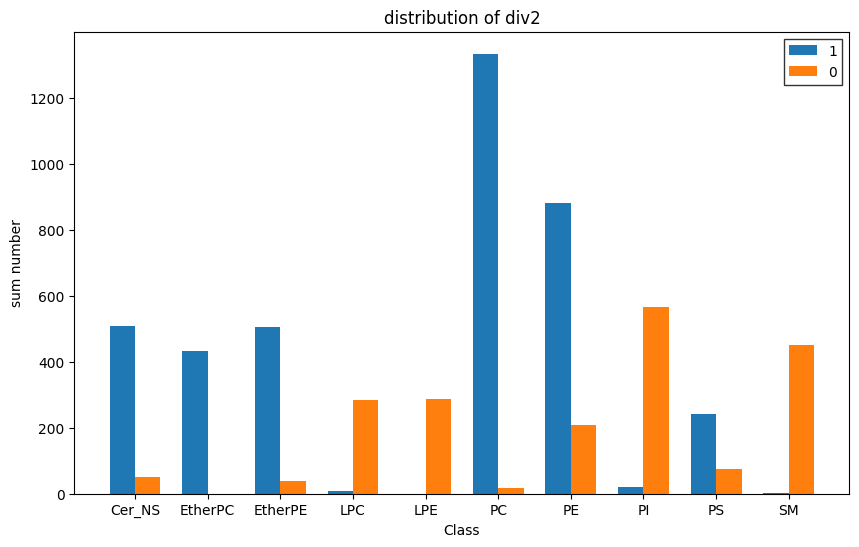

In [151]:
selected_columns = df_neg_data2x[df_neg_data2x['Ontology'].isin(class_list)][['Ontology', 'div2']]

# クラスごとに0と1の出現回数を計算
class_counts = selected_columns.groupby('Ontology')['div2'].value_counts().unstack().fillna(0)

# プロット
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = range(len(class_counts))

bar1 = ax.bar(index, class_counts[1], bar_width, label='1')
bar2 = ax.bar([i + bar_width for i in index], class_counts[0], bar_width, label='0')

ax.set_xlabel('Class')
ax.set_ylabel('sum number')
ax.set_title('distribution of div2')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(class_counts.index)
ax.legend()

plt.show()

In [23]:
unique_ontologies = train_ds['Ontology'].unique()
df_neg_data2x_shap_df1 = pd.DataFrame()
df_neg_data2x_shap_df2 = pd.DataFrame()

for ontology in unique_ontologies:
    ontology_data_train = train_ds[train_ds['Ontology'] == ontology]
    ontology_data_test = test_ds[test_ds['Ontology'] == ontology]
    df_neg_data2x_shap_df1 = pd.concat([df_neg_data2x_shap_df1, ontology_data_train])
    df_neg_data2x_shap_df2 = pd.concat([df_neg_data2x_shap_df2, ontology_data_test])

In [24]:
X_train_shap = df_neg_data2x_shap_df1.drop(columns=columns_to_drop).astype(float).values
y_train_shap = df_neg_data2x_shap_df1['Ontology']
X_test_shap = df_neg_data2x_shap_df2.drop(columns=columns_to_drop).astype(float).values
y_test_shap = df_neg_data2x_shap_df2['Ontology']

In [32]:
import shap
explainer = shap.KernelExplainer(model.predict,X_train_shap)

4/4 [==============================] - 0s 7ms/step


In [34]:
shap_values = explainer.shap_values(X_test_shap)

np.save('Data/03-1_model_shap/neg/neg_shapvalues_ex2.npy', shap_values)

  0%|          | 0/100 [00:00<?, ?it/s]

14900/14900 [==============================] - 81s 5ms/step


In [41]:
from matplotlib.colors import ListedColormap

# NumPy配列を読み込む
shap_values = np.load('Data/03-1_model_shap/neg/neg_shapvalues_ex2.npy')

total_shap_values = np.sum([np.abs(sv) for sv in shap_values], axis=0)
mean_shap_values = np.mean([np.abs(sv) for sv in shap_values], axis=0)

select_ont = ['Cer_NS', 'EtherPC', 'EtherPE', 'LPC','LPE','PC', 'PE', 'PI', 'PS', 'SM'] 
total_shap_values2 = pd.DataFrame(total_shap_values).set_index(y_test_shap.reset_index(drop=False).Ontology).reset_index()
total_shap_values2['Ontology'] = total_shap_values2['Ontology'].apply(lambda x: x if x in select_ont else 'Others')
total_shap_values2 = total_shap_values2.groupby('Ontology').mean()

mean_shap_values2 = pd.DataFrame(mean_shap_values).set_index(y_test_shap.reset_index(drop=False).Ontology).reset_index()
mean_shap_values2['Ontology'] = mean_shap_values2['Ontology'].apply(lambda x: x if x in select_ont else 'Others')
mean_shap_values2 = mean_shap_values2.groupby('Ontology').mean()

feature_names = df_feature['featurename']

# 上位20個の特徴量を抽出
top_features_indices = pd.DataFrame(pd.DataFrame(total_shap_values2).sum(axis=0)).rename(columns={0:'sumvalue'}).sort_values("sumvalue", ascending=False)[:20].reset_index()['index'].tolist()
top_feature_names = feature_names.iloc[top_features_indices]
top_feature_df = pd.DataFrame(mean_shap_values2)[top_features_indices].T
top_feature_df.index = top_feature_names

#カラーマップ
tab20_colors = plt.cm.tab20.colors
selected_colors = [list(color) for color in tab20_colors[:20]]
custom_cmap = ListedColormap(selected_colors, name='custom_tab20')

In [42]:
mean_shap_values2.columns = feature_names
total_shap_values2.columns = feature_names 

excel_file = 'Data/03-1_model_shap/neg/shap_select10_neg.xlsx'
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    pd.DataFrame(mean_shap_values2).transpose().to_excel(writer, sheet_name='Negative shap_mean')
    pd.DataFrame(total_shap_values2).transpose().to_excel(writer, sheet_name='Negative shap_total')

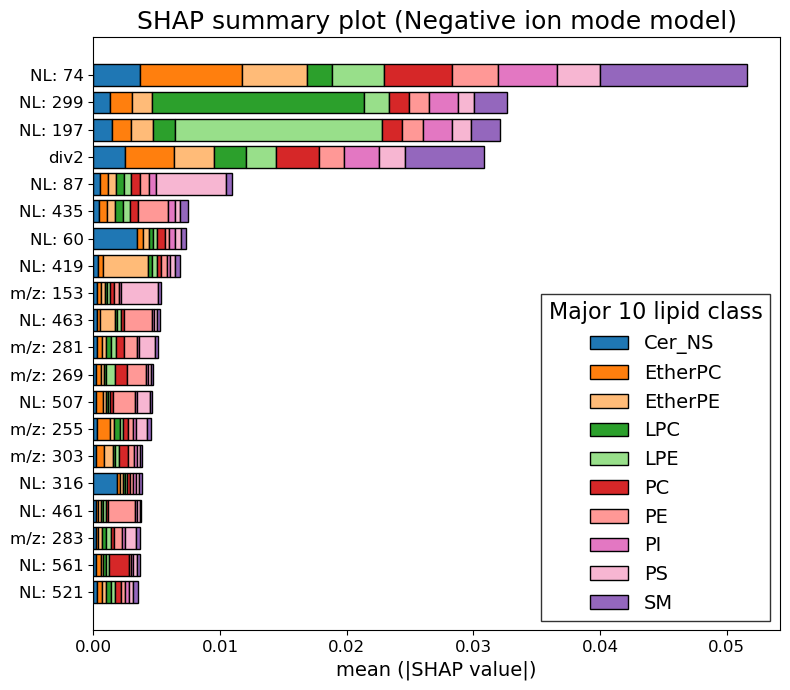

In [43]:
import matplotlib.pyplot as plt

top_feature_df2 = top_feature_df.T
cl = plt.cm.tab20.colors
cmap_NEG = [cl[0], cl[2], cl[3], cl[4], cl[5], cl[6], cl[7], cl[12], cl[13], cl[8]]
custom_legend_order =   ['Cer_NS', 'EtherPC', 'EtherPE', 'LPC','LPE', 'PC', 'PE', 'PI', 'PS', 'SM'] 
top_feature_df2 = top_feature_df2.loc[custom_legend_order]

fig, ax = plt.subplots(figsize=(8, 7))
for i in range(len(top_feature_df2)):
    ax.barh(top_feature_df2.columns, top_feature_df2.iloc[i], left=top_feature_df2.iloc[:i].sum(), color=cmap_NEG[i], ec='black', linewidth=1)#plt.cm.Paired(i / len(top_feature_df2)))
plt.title('SHAP summary plot (Negative ion mode model)', fontsize = 18)
plt.xlabel('mean (|SHAP value|)', fontsize = 14)
plt.ylabel('')
plt.tick_params(labelsize=12)
plt.legend(custom_legend_order, title = 'Major 10 lipid class', fontsize=14, title_fontsize=16) #custom_legend_order,
plt.gca().invert_yaxis()
plt.tight_layout()
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'

plt.savefig('Data/svg/model/shap/neg_shap.svg', format='svg', dpi=300, bbox_inches='tight')

モデルの学習曲線

In [19]:
ls c_final/v1/model/neg_class_model_3

assets/  fingerprint.pb*  keras_metadata.pb*  saved_model.pb*  variables/


In [9]:
model = load_model("c_final/v1/model/neg_class_model_3")

In [21]:
# 描画サイズ 
plt.figure(figsize=(8, 5))

# 学習過程の可視化
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='valid')
plt.xticks(range(0, len(history.epoch)+1, 50))
plt.ylabel('Loss', fontsize=20)  
plt.xlabel('Epochs', fontsize=20)  
plt.title('Learning curves (Negative ion mode NN model)', fontsize=20) 
plt.legend(loc='upper right', fontsize=16)  
plt.savefig('Data/svg/model/learning_curve/neg_learning_curve.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

Train, testにおける正答率

In [10]:
y_pred_train = model.predict(X_train)
y_pred_train_max = np.argmax(y_pred_train, axis=1)
_, y_train_acc = np.where(y_train_onehot > 0) 

y_pred_test = model.predict(X_test)
y_pred_test_max = np.argmax(y_pred_test, axis=1)
_, y_test_acc = np.where(y_test_onehot > 0) 


# 正答率
train_accuracy = accuracy_score(y_train_acc, y_pred_train_max)
test_accuracy = accuracy_score(y_test_acc, y_pred_test_max)

print('Neural Network_train :', train_accuracy)
print('Neural Network_test :', test_accuracy)

52/52 [==============================] - 0s 6ms/step
Neural Network_train : 0.998468606431853
Neural Network_test : 0.9546846295162278


予測結果のまとめ

In [15]:
import seaborn as sns
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}
df_train_x = pd.concat([pd.DataFrame(y_train).reset_index(drop=True),pd.DataFrame(y_pred_train).rename(columns=replacement_dict_reversed)], axis=1).groupby('Ontology').mean()
df_train_x = df_train_x.reindex(sorted(df_train_x.columns), axis=1)


df_train_predclass = pd.DataFrame(y_pred_train).rename(columns=replacement_dict_reversed)

df_train_predclass['pred_1class'] = np.vectorize(replacement_dict_reversed.get)(y_pred_train_max)
df_train_predclass['pred_class'] = df_train_predclass.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_train_predclass['pred_number'] = df_train_predclass['pred_class'].apply(lambda x: len(x.split(',')))

df_train_predclass_v = df_train_predclass[['pred_1class','pred_class','pred_number']]
df_copy = df_neg_data2.drop(columns=columns_to_drop).reset_index().rename(columns={'index':'id'})['id'].copy(deep=True)
df_train_predclass_v = df_train_predclass_v.assign(id=df_copy)

df_train_predclass_v['id'] = y_train.index.tolist()
df_train_predclass_v = df_train_predclass_v.set_index('id')

df_train_predclass.index = y_train.index.tolist()
df_train_predclass.to_csv('Data/03_model/neg/neg_df_train_predclass.csv')

df_mispred = pd.concat([df_train_predclass_v, y_train], axis=1)[y_train_acc != y_pred_train_max]
    
df_mispred['TF'] = df_mispred.apply(base.check_ontology_in_pred_class, axis=1)

pred1st_train =  len(df_train_predclass_v[y_train_acc == y_pred_train_max]) / len(df_train_predclass)
predcandidate_train = (len(df_train_predclass_v[y_train_acc == y_pred_train_max]) + len(df_mispred.query('TF == True'))) / len(df_train_predclass)


print('1st pred :', pred1st_train)
print('candidate :', predcandidate_train)

print('1st pred num:',len(df_train_predclass_v[y_train_acc == y_pred_train_max]))
print('candidate num:',len(df_train_predclass_v[y_train_acc == y_pred_train_max]) + len(df_mispred.query('TF == True')))

print('all num:', len(df_train_predclass))

1st pred : 0.9986600306278713
candidate : 0.9994257274119449
1st pred num: 5217
candidate num: 5221
all num: 5224


In [11]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}
df_test_predclass = pd.DataFrame(y_pred_test).rename(columns=replacement_dict_reversed)

df_test_predclass['pred_1class'] = np.vectorize(replacement_dict_reversed.get)(y_pred_test_max)
df_test_predclass['pred_class'] = df_test_predclass.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_test_predclass['pred_number'] = df_test_predclass['pred_class'].apply(lambda x: len(x.split(',')))

df_test_predclass_v = df_test_predclass[['pred_1class','pred_class','pred_number']]
df_copy = df_neg_data2.drop(columns=columns_to_drop).reset_index().rename(columns={'index':'id'})['id'].copy(deep=True)
df_test_predclass_v = df_test_predclass_v.assign(id=df_copy)

df_test_predclass_v['id'] = test_d.index.tolist()
df_test_predclass_v = df_test_predclass_v.set_index('id')


df_test_predclass.to_csv('Data/03_model/neg/neg_df_test_predclass.csv')

df_mispred = pd.concat([df_test_predclass_v, test_d[['Ontology']]], axis=1)[y_test_acc != y_pred_test_max]
df_mispred['TF'] = df_mispred.apply(base.check_ontology_in_pred_class, axis=1)

pred1st_test =  len(df_test_predclass_v[y_test_acc == y_pred_test_max]) / len(df_test_predclass)
predcandidate_test = (len(df_test_predclass_v[y_test_acc == y_pred_test_max]) + len(df_mispred.query('TF == True'))) / len(df_test_predclass)

print('1st pred :', pred1st_test)
print('candidate :', predcandidate_test)

print('1st pred num:',len(df_test_predclass_v[y_test_acc == y_pred_test_max]))
print('candidate num:',len(df_test_predclass_v[y_test_acc == y_pred_test_max]) + len(df_mispred.query('TF == True')))

print('all num:', len(df_test_predclass))

1st pred : 0.9546846295162278
candidate : 0.9840783833435395
1st pred num: 1559
candidate num: 1607
all num: 1633


In [17]:
df_model_result = pd.DataFrame(data=[len(df_train_predclass_v[y_train_acc == y_pred_train_max]),len(df_train_predclass_v[y_train_acc == y_pred_train_max]) + len(df_mispred.query('TF == True')),len(df_train_predclass), len(df_test_predclass_v[y_test_acc == y_pred_test_max]),len(df_test_predclass_v[y_test_acc == y_pred_test_max]) + len(df_mispred.query('TF == True')),len(df_test_predclass)], \
                               index=['train_1st', 'train_candidate', 'train_number','test_1st', 'test_candidate','test_number'])
df_model_result.to_csv('Data/03_model/neg/df_neg_model_pred_result.csv')

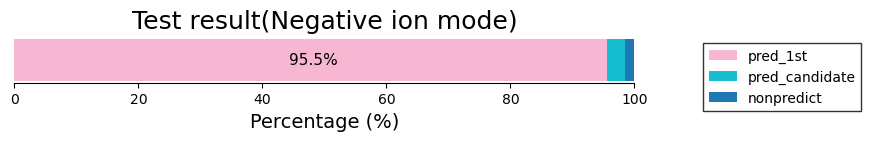

In [32]:
import matplotlib.pyplot as plt

# データの準備
test_pred_1st = round(pred1st_test * 100, 1)
test_pred_candidate = round(predcandidate_test * 100, 1)
percentages = [test_pred_1st, test_pred_candidate-test_pred_1st, 100-test_pred_candidate]
percentages2 = [f'{test_pred_1st}%','','']#round(test_pred_candidate-test_pred_1st, 1), ]
categories = ["pred_1st", "pred_candidate", "nonpredict"]

fig = plt.figure(figsize=(8, 0.6))  # figsizeを調整して適切なサイズに設定
bar_width = 0.6

# バーの中心位置を計算
bar_centers = [ percentages[0]/2, percentages[0] + percentages[1]/2, percentages[0] + percentages[1] + percentages[2]/2,]
cl = plt.cm.tab20.colors
deep_palette = [cl[18], cl[13], cl[0]]

# 水平な積み上げ棒グラフを描画
bars = plt.barh(1, percentages[0], height=bar_width, color=deep_palette[1], label='pred_1st')
plt.barh(1, percentages[1], left=percentages[0], height=bar_width, color=deep_palette[0], label='pred_candidate')
plt.barh(1, percentages[2], left=percentages[0] + percentages[1], height=bar_width, color=deep_palette[2], label='nonpredict')
# パーセントラベルを描画
for category, center, percentage in zip(categories, bar_centers, percentages2):
    plt.text(center+0.5, 1, percentage, ha='center', va='center', fontsize=11, color='black')
#f'{percentage}%'
    
# ラベルを設定
plt.xlabel('Percentage (%)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.yticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.xlim(0, 100) 
plt.title('Test result(Negative ion mode)', fontsize=18)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('Data/svg/model/result/neg/neg_testresult_percentage.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
df_train = pd.DataFrame(y_train)
df_train['data'] = 'train'

df_test = pd.DataFrame(y_test)
df_test['data'] = 'test'

df_eval= pd.DataFrame(y_eval)
df_eval['data'] = 'eval'

df_3type = pd.concat([df_train, df_test, df_eval], axis=0).reset_index().rename(columns={'index':'id'}).drop('Ontology', axis=1)

pred_df = pd.merge(df_neg_data2[['Metabolitename', 'Ontology']].reset_index().rename(columns={'index':'id'}), df_3type, on='id', how='left')

test_1stpred = df_test_predclass_v[y_test_acc == y_pred_test_max].reset_index().id
test_candidate = df_mispred.query('TF == True').reset_index().rename(columns={'index':'id'}).id
test_false = df_mispred.query('TF == False').reset_index().rename(columns={'index':'id'}).id

pred_df.loc[pred_df['id'].isin(test_1stpred), 'data'] = 'test: 1st pred'
pred_df.loc[pred_df['id'].isin(test_candidate), 'data'] = 'test: candidate'
pred_df.loc[pred_df['id'].isin(test_false), 'data'] = 'test: non predicted'

In [20]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

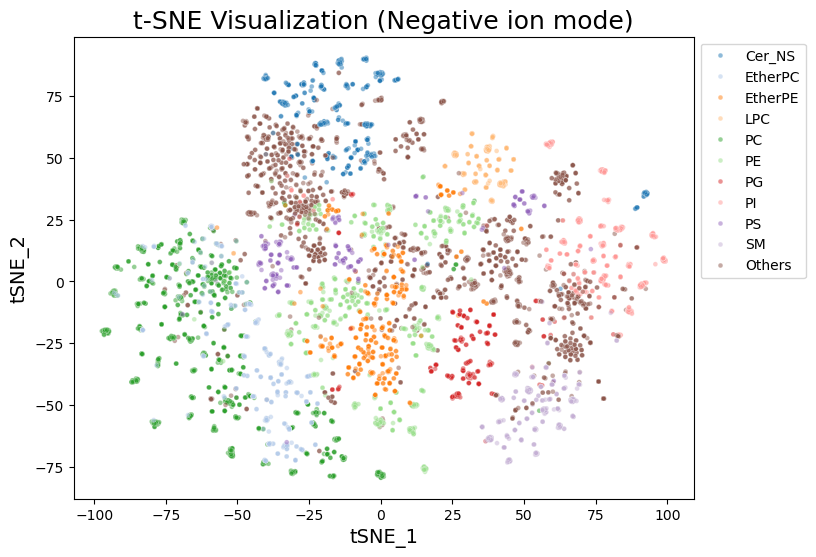

In [22]:
plt.rcParams.update(plt.rcParamsDefault)

select_ont = ['PC', 'PE', 'PI', 'Cer_NS', 'EtherPE', 'SM', 'EtherPC', 'PS', 'PG', 'LPC']
pred_df['select_ont'] = pred_df['Ontology'].apply(lambda x: x if x in select_ont else 'Others')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=pred_df['select_ont'], palette='tab20', s=12, alpha=0.5, hue_order=['Cer_NS', 'EtherPC','EtherPE', 'LPC','PC','PE','PG','PI','PS','SM', 'Others'])
plt.title('t-SNE Visualization (Negative ion mode)', fontsize = 18)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.savefig('Data/svg/model/result/neg/neg_test_tsne_color-by-ontology.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

canopusとの比較用データの準備

In [12]:
df_allexp = pd.concat([df_test_predclass_v, y_test], axis=1)
df_allexp['TF'] = df_allexp.apply(base.check_ontology_in_pred_class, axis=1)
select_ont = pd.read_csv('Data/04_canopus/neg/subclass_ont_select_neg.csv')

In [13]:
df_allexp2 = pd.merge(df_allexp.reset_index(), select_ont, on='Ontology', how='inner').rename(columns={'subclass':'cor_subclass'})
df_allexp2 = pd.merge(df_allexp2, select_ont, left_on = 'pred_1class', right_on = 'Ontology', how='inner').rename(columns={'subclass':'pred_subclass','Ontology_y':'pred_ont'})
df_allexp2.to_csv('Data/04_canopus/neg/df_neg_subclass_pred_ont.csv')

In [14]:
import pandas as pd

subclasslist = ['Glycerophosphoethanolamines',
 'Glycerophosphocholines',
 'Ceramides',
 'Glycerophosphoinositols',
 'Glycerophosphoglycerols',
 'Glycerophosphoserines',
 'Phosphosphingolipids',
 'Fatty acids and conjugates']

df_neg_subclass_pred = pd.DataFrame(columns=['Subclass', 'Correct_Predictions', 'Incorrect_Predictions', 'Total'])

for i in subclasslist:
    df_allexp2_i = df_allexp2[df_allexp2['cor_subclass'] == i]
    correct_predictions = len(df_allexp2_i[df_allexp2_i['cor_subclass'] == df_allexp2_i['pred_subclass']])
    incorrect_predictions = len(df_allexp2_i) - correct_predictions
    total_samples = len(df_allexp2_i)

    new_row = {'Subclass': i,
               'Correct_Predictions': correct_predictions,
               'Incorrect_Predictions': incorrect_predictions,
               'Total': total_samples}
    
    # ループ内でデータを追加
    df_neg_subclass_pred = pd.concat([df_neg_subclass_pred, pd.DataFrame([new_row])], ignore_index=True)

# ループが終了した後でCSVファイルに保存
df_neg_subclass_pred.to_csv('Data/04_canopus/neg/df_neg_subclass_pred.csv', index=False)